In [10]:
from scipy.integrate import odeint
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys
sys.path.append('../../src')
from diffusion_maps_tools import *
# Matplotlib setup
plt.style.use('seaborn-white')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('axes', labelsize=20)
plt.rc('font', family='serif') 

### Parameters compared to the fig of the paper
- $k_1 = k_{on1}$ 0
- $k_2 = k_{off1}$ 1
- $k_3 = k_{cat1}$ 2
- $k_4 = k_{off2}$ 3
- $k_5 = k_{on2}$ 4
- $k_6 = k_{cat2}$ 5


- $x[0] = S_0$
- $x[1] = C_1$
- $x[2] = C_2$
- $x[3] = S_1$
- $x[4] = S_2$
- $x[5] = E$

In [2]:
# ODE setup
def midlevel_MEK_ERK_model(x, t, k1, k2, k3, k4, k5, k6):
    x0d = -k1*x[0]*x[5] + k2*x[1]
    x1d = k1*x[0]*x[5] - k2*x[1] - k3*x[1];
    x2d = k3*x[1] - k4*x[2] + k5*x[5]*x[3] - k6*x[2];
    x3d = k4*x[2] - k5*x[5]*x[3];
    x4d = k6*x[2];
    x5d = -k1*x[5]*x[0] + k2*x[1] + k4*x[2] - k5*x[5]*x[3] + k6*x[2];
    # return the state derivatives
    return [x0d, x1d, x2d, x3d, x4d, x5d]

In [26]:
# Parameters
k1 = 0.71;  # (uM*min)^-1, kon2
k2 = 19;    # min^-1
k3 = 6700;  # min^-1
k4 = 9200;  # min^-1
k5 = 0.97;  # (uM*min)^-1, kon1
k6 = 5200;  # min^-1
# Initial Condition
x0 = [5,0,0,0,0,0.66]
# Time span
t  = np.linspace(0,20,100)
sol = odeint(midlevel_MEK_ERK_model,
             x0,
             t,
             args = (k1,k2,k3,k4,k5,k6,))

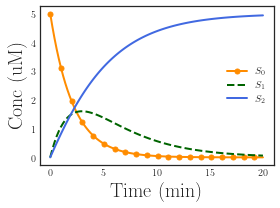

In [52]:
fig, ax = plt.subplots(1,1, figsize=(4,3))
ax.plot(t,sol[:,0], '-o', label=r'$S_0$', markersize=5, markevery=5, linewidth=2, color='darkorange')
ax.plot(t,sol[:,3], '--', label=r'$S_1$', linewidth=2, color='darkgreen')
ax.plot(t,sol[:,4], label=r'$S_2$', linewidth=2, color='royalblue')
ax.set_ylabel(r'Conc (uM)')
ax.set_xlabel(r'Time (min)')
plt.legend();
plt.tight_layout()
plt.savefig('conc_time.pdf')

In [5]:
# Initial Condition
np.random.seed(12345)
x0 = [5,0,0,0,0,0.66]
n_sample = 1000
n_time_step = 11
tpick = np.linspace(0,20,n_time_step)
delk = 0.1
dmap_data = np.zeros((n_sample, n_time_step-1))
K_data    = np.zeros((n_sample, 6))
for i in range(n_sample):
    k1 = np.random.uniform(0.71-delk*0.71, 0.71+delk*0.71)
    k2 = np.random.uniform(19-delk*19, 19+delk*19)
    k3 = np.random.uniform(6700-delk*6700, 6700+delk*6700)
    k4 = np.random.uniform(9200-delk*9200, 9200+delk*9200)
    k5 = np.random.uniform(0.97-delk*0.97, 0.97+delk*0.97)
    k6 = np.random.uniform(5200-delk*5200, 5200+delk*5200)
    sol = odeint(midlevel_MEK_ERK_model,x0,
             tpick,
             args = (k1,k2,k3,k4,k5,k6,))
    # Observe S2 in 10 time snapshots
    dmap_data[i,:] = sol[1:,4]
    # Store the K values
    K_data[i,:] = [k1,k2,k3,k4,k5,k6]

In [6]:
DiffMaps = diffusion_maps_tools()
num_eigenpairs = 20
epsilon = 1.0
distance = DiffMaps.distance(points = dmap_data)
kernel = DiffMaps.kernel(metric = distance, epsilon=epsilon*2)
kernel = DiffMaps.ker_normalize(kernel, alpha=1.0)
eigval, phi = DiffMaps.eigensolver(matrix = kernel,
                                   num_eigenpairs = num_eigenpairs)
print('    Eigenvalues are = {}'.format(eigval.real))

  > Dataset: 1000 points in 10 dimensions
  > Compute distances with pdist
  --> Distance matrix is 100.0000% dense.
  > Compute Kernel
  > Compute Normalized Kernel with alpha=1.000000
  > Compute First 20 Eigenvectors
    Eigenvalues are = [1.00000000e+00 6.13681359e-02 3.57962514e-03 1.74416591e-03
 1.94715237e-04 7.65292791e-05 8.49729724e-06 3.43826374e-06
 3.10098005e-06 1.94156427e-06 2.81505564e-07 1.38052862e-07
 1.19243725e-07 7.00875664e-08 8.86298928e-09 4.96646959e-09
 3.84896700e-09 2.80286521e-09 2.27929140e-09 1.46744921e-09]


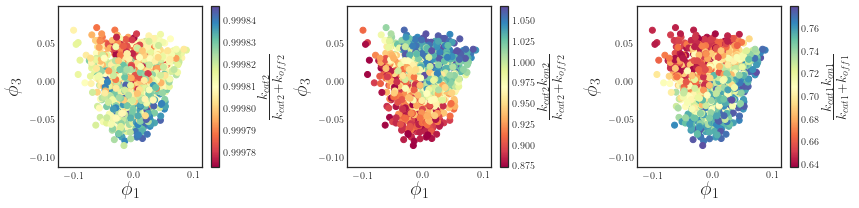

In [51]:
fig = plt.figure(figsize=(12,3))
ax = plt.subplot(131)
p = ax.scatter(phi[:,1], phi[:,3], 
               c=K_data[:,5]/(K_data[:,5]+K_data[:,4]), 
               cmap='Spectral',
               rasterized=True)
cs = plt.colorbar(p, ax=ax)
cs.set_label(r'$\frac{k_{cat2}}{k_{cat2}+k_{off2}}$');
ax.set_xlabel(r'$\phi_1$');
ax.set_ylabel(r'$\phi_3$');

ax = plt.subplot(132)
p = ax.scatter(phi[:,1], phi[:,3], 
               c=(K_data[:,5]*K_data[:,4])/(K_data[:,5]+K_data[:,4]), 
               cmap='Spectral',
               rasterized='True')
cs = plt.colorbar(p, ax=ax)
cs.set_label(r'$\frac{k_{cat2}k_{on2}}{k_{cat2}+k_{off2}}$');
ax.set_xlabel(r'$\phi_1$');
ax.set_ylabel(r'$\phi_3$');


ax = plt.subplot(133)
p = ax.scatter(phi[:,1], phi[:,3], 
               c=(K_data[:,0]*K_data[:,2])/(K_data[:,1]+K_data[:,2]), 
               cmap='Spectral',
               rasterized='True')
cs = plt.colorbar(p, ax=ax)
cs.set_label(r'$\frac{k_{cat1}k_{on1}}{k_{cat1}+k_{off1}}$');
ax.set_xlabel(r'$\phi_1$');
ax.set_ylabel(r'$\phi_3$');

plt.tight_layout()
plt.savefig('dmap_coor.pdf')